Getting the Datasets using Open datasets

In [ ]:
!pip install opendatasets
import opendatasets as od

od.download("https://www.kaggle.com/datasets/nirmalsankalana/cassava-leaf-disease-classification")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: Lynn Amoit
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/nirmalsankalana/cassava-leaf-disease-classification


100%|██████████| 2.39G/2.39G [00:35<00:00, 72.8MB/s]


Shifting the Dataset to google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


Setting the data path

In [ ]:
DATASET_PATH = "/content/drive/MyDrive/cassava-leaf-disease-classification/data"


Data Collection

In [ ]:
from pathlib import Path

# Path to cassava dataset
base_path = Path("/content/drive/MyDrive/cassava-leaf-disease-classification/data")

# Verify dataset folder exists
if not base_path.exists():
    raise FileNotFoundError(f"Dataset folder not found: {base_path}")

print(f"✓ Dataset folder found at: {base_path}\n")

# Count images per class
print("Dataset Structure:\n")

total_images = 0
for class_folder in base_path.iterdir():
    if class_folder.is_dir():
        image_count = len(list(class_folder.glob("*.*")))
        total_images += image_count
        print(f"  - {class_folder.name}: {image_count} images")

print(f"\nTotal dataset images: {total_images}")

# Pretty folder structure
print("\nFolder Structure:")
print("cassava-leaf-disease-classification/")
print("  └── data/")
print("      ├── Cassava___bacterial_blight/")
print("      ├── Cassava___brown_streak_disease/")
print("      ├── Cassava___green_mottle/")
print("      ├── Cassava___mosaic_disease/")
print("      └── Cassava___healthy/")


✓ Dataset folder found at: /content/drive/MyDrive/cassava-leaf-disease-classification/data

Dataset Structure:

  - Cassava___bacterial_blight: 1087 images
  - Cassava___brown_streak_disease: 2189 images
  - Cassava___green_mottle: 2386 images
  - Cassava___healthy: 2577 images
  - Cassava___mosaic_disease: 10179 images

Total dataset images: 18418

Folder Structure:
cassava-leaf-disease-classification/
  └── data/
      ├── Cassava___bacterial_blight/
      ├── Cassava___brown_streak_disease/
      ├── Cassava___green_mottle/
      ├── Cassava___mosaic_disease/
      └── Cassava___healthy/


DATA PREPROCESSING


 Define classes and labels

In [3]:
from pathlib import Path
import numpy as np
import tensorflow as tf

DATASET_PATH = Path("/content/drive/MyDrive/cassava-leaf-disease-classification/data")

# Map class folder names to numeric labels
class_map = {
    "Cassava___bacterial_blight": 0,
    "Cassava___brown_streak_disease": 1,
    "Cassava___green_mottle": 2,
    "Cassava___mosaic_disease": 3,
    "Cassava___healthy": 4
}


Collecting image paths and labels

In [4]:
all_image_paths = []
all_labels = []

for class_name, label in class_map.items():
    class_folder = DATASET_PATH / class_name
    image_files = list(class_folder.glob("*.jpg"))

    for img in image_files:
        all_image_paths.append(str(img))
        all_labels.append(label)

all_image_paths = np.array(all_image_paths)
all_labels = np.array(all_labels)

print(f"Total images: {len(all_image_paths)}")

for class_name, label in class_map.items():
    print(f"{class_name}: {np.sum(all_labels == label)} images")


Total images: 18418
Cassava___bacterial_blight: 1087 images
Cassava___brown_streak_disease: 2189 images
Cassava___green_mottle: 2386 images
Cassava___mosaic_disease: 10179 images
Cassava___healthy: 2577 images


Splitting Data into Training and Validation Dataset

In [6]:
import tensorflow as tf

def load_image(image_path, label, img_size=(224, 224)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, img_size)
    return image / 255.0, label

def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    return image, label


In [7]:
from sklearn.model_selection import train_test_split

# Split data into train and validation sets (80-20 split)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_image_paths,
    all_labels,
    test_size=0.2,
    random_state=42,
    stratify=all_labels  # keeps distribution equal
)

# TensorFlow Dataset Parameters
batch_size = 32
img_size = (224, 224)

# ---------------------------- #
#   Training Dataset
# ---------------------------- #
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = train_ds.map(lambda x, y: load_image(x, y, img_size),
                        num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.map(augment_image,
                        num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.batch(batch_size)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

# ---------------------------- #
#   Validation Dataset
# ---------------------------- #
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_ds = val_ds.map(lambda x, y: load_image(x, y, img_size),
                    num_parallel_calls=tf.data.AUTOTUNE)

val_ds = val_ds.batch(batch_size)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

# ---------------------------- #
#   Summary
# ---------------------------- #
print(f"Training samples: {len(train_paths)}")
print(f"Validation samples: {len(val_paths)}")
print(f"Batch size: {batch_size}")
print(f"Image size: {img_size}")
print("\nClasses:")
print(class_map)


Training samples: 14734
Validation samples: 3684
Batch size: 32
Image size: (224, 224)

Classes:
{'Cassava___bacterial_blight': 0, 'Cassava___brown_streak_disease': 1, 'Cassava___green_mottle': 2, 'Cassava___mosaic_disease': 3, 'Cassava___healthy': 4}


Exploratory Data Analysis

Counting Images per class

In [ ]:
import os

DATASET_PATH = "/content/drive/MyDrive/cassava-leaf-disease-classification/data"

for folder in os.listdir(DATASET_PATH):
    class_path = os.path.join(DATASET_PATH, folder)
    if os.path.isdir(class_path):
        print(f"{folder}: {len(os.listdir(class_path))} images")


Cassava___mosaic_disease: 10179 images
Cassava___bacterial_blight: 1087 images
Cassava___brown_streak_disease: 2189 images
Cassava___green_mottle: 2386 images
Cassava___healthy: 2577 images


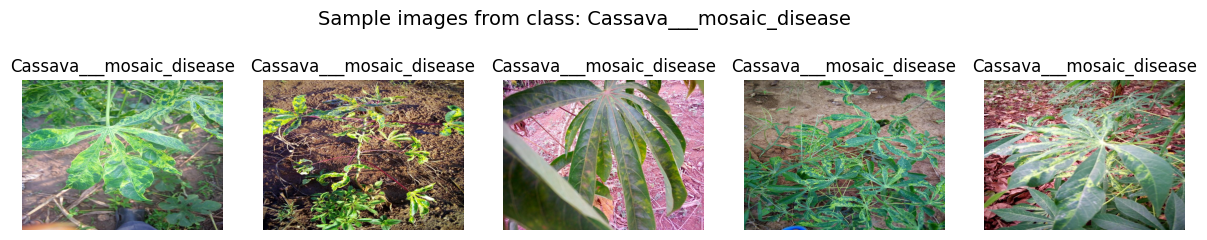

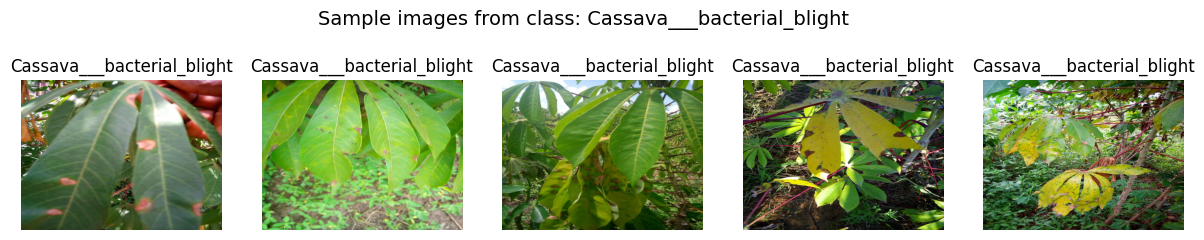

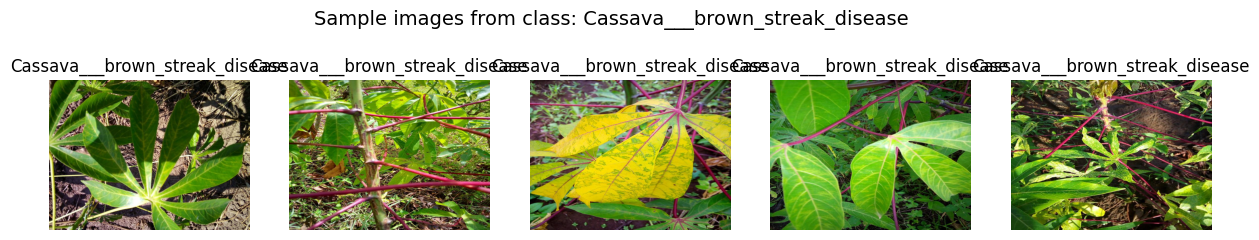

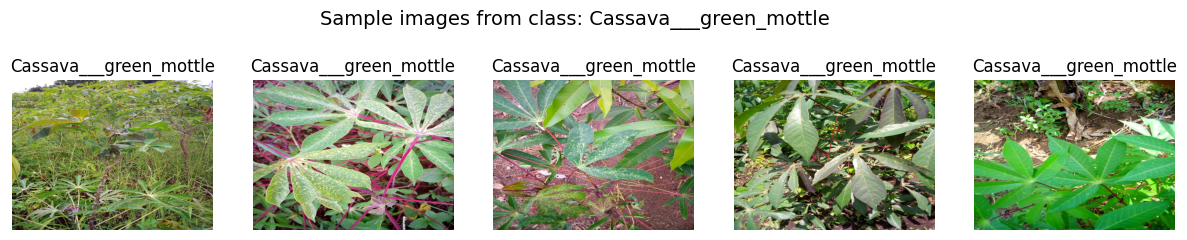

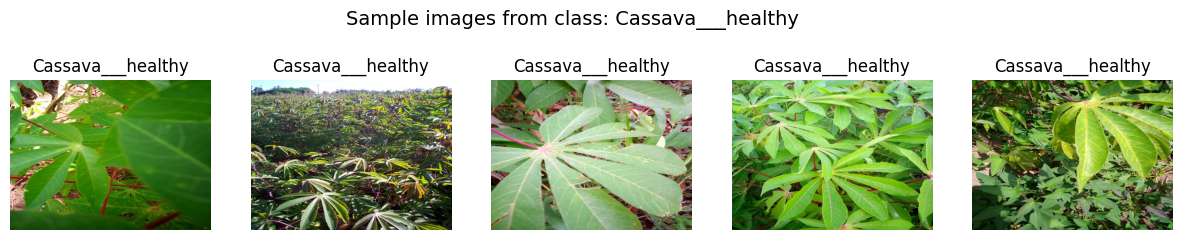

In [ ]:
import matplotlib.pyplot as plt
import os
import random

DATASET_PATH = "/content/drive/MyDrive/cassava-leaf-disease-classification/data"

def visualize_samples_per_class(path, samples=5):
    classes = os.listdir(path)
    classes = [c for c in classes if os.path.isdir(os.path.join(path, c))]

    for cls in classes:
        class_path = os.path.join(path, cls)
        image_files = os.listdir(class_path)

        # Select 5 random images
        chosen = random.sample(image_files, min(samples, len(image_files)))

        plt.figure(figsize=(15, 3))
        for i, img_name in enumerate(chosen):
            img_path = os.path.join(class_path, img_name)
            img = plt.imread(img_path)

            plt.subplot(1, samples, i+1)
            plt.imshow(img)
            plt.title(cls)
            plt.axis("off")

        plt.suptitle(f"Sample images from class: {cls}", fontsize=14)
        plt.show()

# Run visualization
visualize_samples_per_class(DATASET_PATH)


In [ ]:
!ls "/content/drive/MyDrive/cassava-leaf-disease-classification/data"


Cassava___bacterial_blight	Cassava___healthy
Cassava___brown_streak_disease	Cassava___mosaic_disease
Cassava___green_mottle


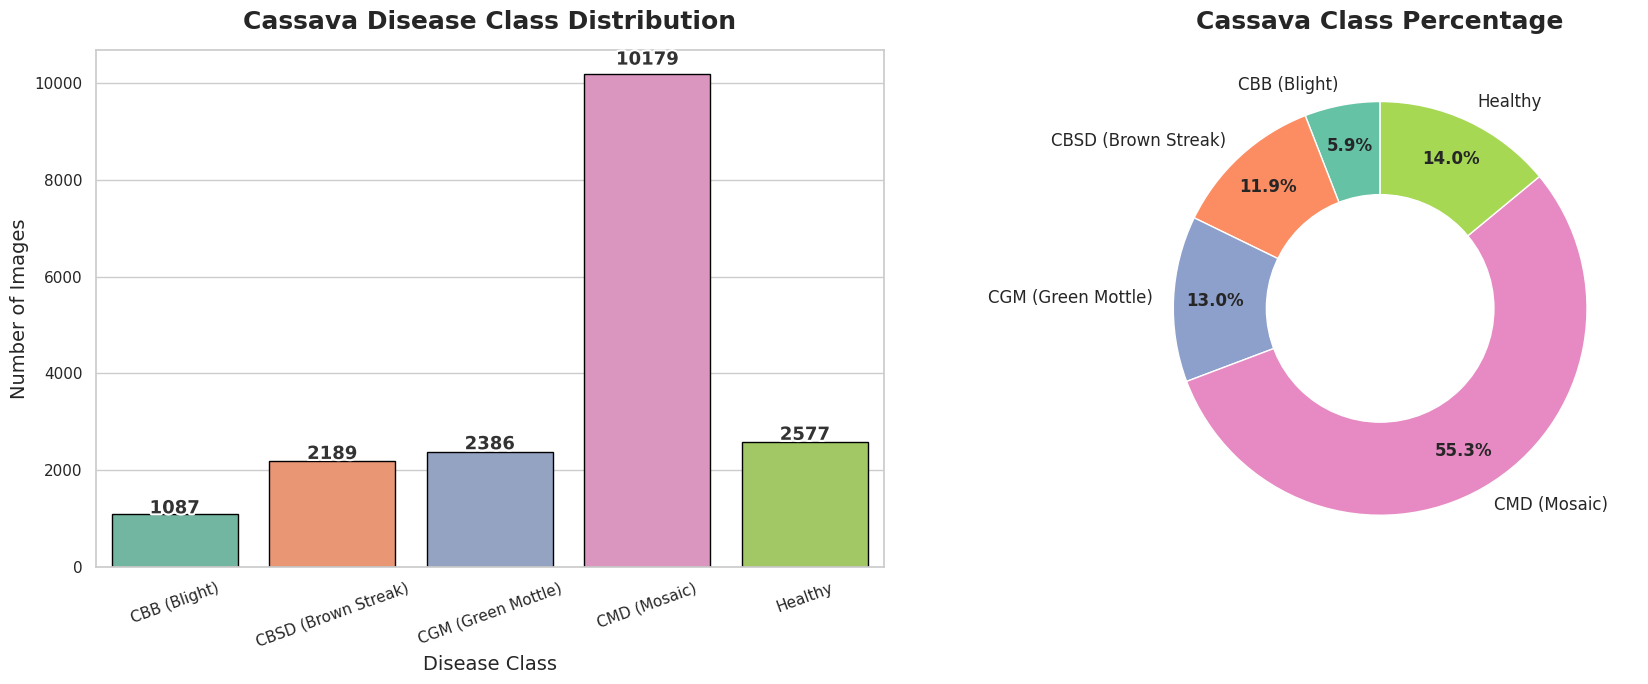

Cassava Class Distribution Summary:
  CBB (Blight): 1087 images (5.9%)
  CBSD (Brown Streak): 2189 images (11.9%)
  CGM (Green Mottle): 2386 images (13.0%)
  CMD (Mosaic): 10179 images (55.3%)
  Healthy: 2577 images (14.0%)

Total Images: 18418


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import numpy as np
import seaborn as sns

# Professional seaborn style
sns.set_theme(style="whitegrid")

# Class names
class_names = [
    "CBB (Blight)",
    "CBSD (Brown Streak)",
    "CGM (Green Mottle)",
    "CMD (Mosaic)",
    "Healthy"
]

# Class counts
class_counts = [np.sum(all_labels == i) for i in range(5)]

# Elegant professional color palette
colors = sns.color_palette("Set2", 5)

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# ================================
#       BAR PLOT (LEFT)
# ================================
sns.barplot(
    x=class_names,
    y=class_counts,
    palette=colors,
    hue=class_names,       # Fix for seaborn >=0.14
    legend=False,
    ax=axes[0],
    edgecolor="black"
)

axes[0].set_title("Cassava Disease Class Distribution", fontsize=18, fontweight="bold", pad=15)
axes[0].set_ylabel("Number of Images", fontsize=14)
axes[0].set_xlabel("Disease Class", fontsize=14)
axes[0].tick_params(axis="x", rotation=20)

# Text labels with stroke
for i, v in enumerate(class_counts):
    axes[0].text(
        i, v + (v * 0.02),
        str(v),
        ha="center",
        fontsize=13,
        fontweight="bold",
        color="#333",
        path_effects=[path_effects.withStroke(linewidth=3, foreground="white")]
    )

# ================================
#          PIE CHART (RIGHT)
# ================================
wedges, texts, autotexts = axes[1].pie(
    class_counts,
    labels=class_names,
    autopct="%1.1f%%",
    colors=colors,
    startangle=90,
    pctdistance=0.8,
    textprops={"fontsize": 12}
)

# Style pie chart text
for t in autotexts:
    t.set_fontsize(12)
    t.set_fontweight("bold")

axes[1].set_title("Cassava Class Percentage", fontsize=18, fontweight="bold", pad=15)

# Donut hole for professional look
centre_circle = plt.Circle((0, 0), 0.55, fc='white')
axes[1].add_artist(centre_circle)

# ================================
#       FINAL LAYOUT
# ================================
plt.tight_layout()
plt.show()

# ================================
#       PRINT SUMMARY
# ================================
print("Cassava Class Distribution Summary:")
for i, count in enumerate(class_counts):
    print(f"  {class_names[i]}: {count} images ({count / len(all_labels) * 100:.1f}%)")
print(f"\nTotal Images: {len(all_labels)}")


In [ ]:
import os
from PIL import Image, UnidentifiedImageError

DATASET_PATH = "/content/cassava-leaf-disease-classification/data"  # <-- change if needed

def check_corrupted_images(dataset_path):
    corrupted = []
    total = 0

    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            file_path = os.path.join(root, file)
            total += 1
            try:
                # Open and verify image
                with Image.open(file_path) as img:
                    img.verify()
            except (UnidentifiedImageError, OSError, ValueError) as e:
                print("Corrupted or unreadable:", file_path, "->", e)
                corrupted.append(file_path)

    print("\nTotal files checked:", total)
    print("Total corrupted files:", len(corrupted))
    return corrupted

corrupted_files = check_corrupted_images(DATASET_PATH)



Total files checked: 0
Total corrupted files: 0


MODEL TRAINING

Baseline CNN

In [8]:
from sklearn.utils.class_weight import compute_class_weight


Define Call backs

In [9]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_baseline_model.h5",
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=2,
    verbose=1
)

callbacks = [early_stop, checkpoint, reduce_lr]


In [10]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(all_labels),
    y=all_labels
)

class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


Class Weights: {0: np.float64(3.388776448942042), 1: np.float64(1.682777523983554), 2: np.float64(1.5438390611902766), 3: np.float64(0.3618823067098929), 4: np.float64(1.4294140473418704)}


In [ ]:
baseline_model = tf.keras.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    layers.MaxPooling2D(2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),

    layers.Dense(5, activation='softmax')
])

baseline_model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,245,957 (84.86 MB)

 Trainable params: 22,245,957 (84.86 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
baseline_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


Training the CNN model

In [ ]:
history_cnn = baseline_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    class_weight=class_weights,    # IMPORTANT
    callbacks=callbacks            # IMPORTANT
)


Epoch 1/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.1826 - loss: 1.6914
Epoch 1: val_loss improved from inf to 1.61074, saving model to best_baseline_model.h5


461/461 ━━━━━━━━━━━━━━━━━━━━ 3188s 7s/step - accuracy: 0.1825 - loss: 1.6912 - val_accuracy: 0.1186 - val_loss: 1.6107 - learning_rate: 0.0010
Epoch 2/20
460/461 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.1025 - loss: 1.6170
Epoch 2: val_loss improved from 1.61074 to 1.60867, saving model to best_baseline_model.h5


461/461 ━━━━━━━━━━━━━━━━━━━━ 121s 247ms/step - accuracy: 0.1027 - loss: 1.6169 - val_accuracy: 0.0589 - val_loss: 1.6087 - learning_rate: 0.0010
Epoch 3/20
460/461 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.1322 - loss: 1.6171
Epoch 3: val_loss improved from 1.60867 to 1.60709, saving model to best_baseline_model.h5


461/461 ━━━━━━━━━━━━━━━━━━━━ 120s 244ms/step - accuracy: 0.1323 - loss: 1.6171 - val_accuracy: 0.5527 - val_loss: 1.6071 - learning_rate: 0.0010
Epoch 4/20
460/461 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.1568 - loss: 1.6146
Epoch 4: val_loss did not improve from 1.60709
461/461 ━━━━━━━━━━━━━━━━━━━━ 121s 247ms/step - accuracy: 0.1568 - loss: 1.6146 - val_accuracy: 0.0589 - val_loss: 1.6075 - learning_rate: 0.0010
Epoch 5/20
460/461 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.1456 - loss: 1.6181
Epoch 5: val_loss did not improve from 1.60709

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
461/461 ━━━━━━━━━━━━━━━━━━━━ 119s 244ms/step - accuracy: 0.1458 - loss: 1.6180 - val_accuracy: 0.1189 - val_loss: 1.6078 - learning_rate: 0.0010
Epoch 6/20
460/461 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.2049 - loss: 1.6120
Epoch 6: val_loss did not improve from 1.60709
461/461 ━━━━━━━━━━━━━━━━━━━━ 117s 241ms/step - accuracy: 0.2049 - loss: 1.6120 - va

Training the MobileNetV2 Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models


In [ ]:
IMG_SIZE = (224, 224)

base_model = MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False  # Freeze backbone

inputs = layers.Input(shape=IMG_SIZE + (3,))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(5, activation="softmax")(x)

model = models.Model(inputs, outputs)

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


Model Training

In [ ]:
history_mobilenet = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    class_weight=class_weights,
    callbacks=callbacks
)


Epoch 1/15
461/461 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3939 - loss: 1.5457
Epoch 1: val_loss improved from inf to 1.01157, saving model to best_baseline_model.h5


461/461 ━━━━━━━━━━━━━━━━━━━━ 3912s 8s/step - accuracy: 0.3941 - loss: 1.5454 - val_accuracy: 0.6094 - val_loss: 1.0116 - learning_rate: 0.0010
Epoch 2/15
460/461 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.5556 - loss: 1.1907
Epoch 2: val_loss improved from 1.01157 to 0.97153, saving model to best_baseline_model.h5


461/461 ━━━━━━━━━━━━━━━━━━━━ 109s 223ms/step - accuracy: 0.5556 - loss: 1.1905 - val_accuracy: 0.6295 - val_loss: 0.9715 - learning_rate: 0.0010
Epoch 3/15
459/461 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.5802 - loss: 1.1390
Epoch 3: val_loss did not improve from 0.97153
461/461 ━━━━━━━━━━━━━━━━━━━━ 107s 218ms/step - accuracy: 0.5803 - loss: 1.1390 - val_accuracy: 0.5687 - val_loss: 1.0954 - learning_rate: 0.0010
Epoch 4/15
460/461 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.5827 - loss: 1.1089
Epoch 4: val_loss improved from 0.97153 to 0.93510, saving model to best_baseline_model.h5


461/461 ━━━━━━━━━━━━━━━━━━━━ 106s 217ms/step - accuracy: 0.5828 - loss: 1.1088 - val_accuracy: 0.6433 - val_loss: 0.9351 - learning_rate: 0.0010
Epoch 5/15
459/461 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.5952 - loss: 1.0728
Epoch 5: val_loss did not improve from 0.93510
461/461 ━━━━━━━━━━━━━━━━━━━━ 142s 217ms/step - accuracy: 0.5952 - loss: 1.0729 - val_accuracy: 0.5375 - val_loss: 1.1342 - learning_rate: 0.0010
Epoch 6/15
460/461 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.5914 - loss: 1.1073
Epoch 6: val_loss did not improve from 0.93510

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
461/461 ━━━━━━━━━━━━━━━━━━━━ 141s 216ms/step - accuracy: 0.5914 - loss: 1.1072 - val_accuracy: 0.6498 - val_loss: 0.9467 - learning_rate: 0.0010
Epoch 7/15
461/461 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.6118 - loss: 1.0573
Epoch 7: val_loss did not improve from 0.93510
461/461 ━━━━━━━━━━━━━━━━━━━━ 142s 218ms/step - accuracy: 0.6118 - loss: 1.0572 - va

In [ ]:
model.save("mobilenetv2_frozen.h5")


In [ ]:
!cp mobilenetv2_frozen.h5 "/content/drive/MyDrive/cassava-leaf-disease-classification/"


Unfreezing mobilenetv2


In [ ]:
base_model.trainable = True

# Optional: freeze first 60% of layers to avoid overfitting
for layer in base_model.layers[:100]:
    layer.trainable = False


Recompile with lower LR

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


Fine Tuning with only 5 epochs

In [ ]:
history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    class_weight=class_weights,
    callbacks=callbacks
)


Epoch 1/5
461/461 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3300 - loss: 1.6175
Epoch 1: val_loss improved from inf to 1.26218, saving model to best_baseline_model.h5


461/461 ━━━━━━━━━━━━━━━━━━━━ 2957s 6s/step - accuracy: 0.3301 - loss: 1.6172 - val_accuracy: 0.4731 - val_loss: 1.2622 - learning_rate: 1.0000e-05
Epoch 2/5
461/461 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.5351 - loss: 1.2366
Epoch 2: val_loss improved from 1.26218 to 0.98789, saving model to best_baseline_model.h5


461/461 ━━━━━━━━━━━━━━━━━━━━ 117s 241ms/step - accuracy: 0.5351 - loss: 1.2366 - val_accuracy: 0.6116 - val_loss: 0.9879 - learning_rate: 1.0000e-05
Epoch 3/5
460/461 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.5919 - loss: 1.0933
Epoch 3: val_loss improved from 0.98789 to 0.89967, saving model to best_baseline_model.h5


461/461 ━━━━━━━━━━━━━━━━━━━━ 112s 230ms/step - accuracy: 0.5919 - loss: 1.0932 - val_accuracy: 0.6534 - val_loss: 0.8997 - learning_rate: 1.0000e-05
Epoch 4/5
460/461 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.6236 - loss: 1.0182
Epoch 4: val_loss improved from 0.89967 to 0.84268, saving model to best_baseline_model.h5


461/461 ━━━━━━━━━━━━━━━━━━━━ 111s 229ms/step - accuracy: 0.6237 - loss: 1.0181 - val_accuracy: 0.6805 - val_loss: 0.8427 - learning_rate: 1.0000e-05
Epoch 5/5
460/461 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.6531 - loss: 0.9389
Epoch 5: val_loss improved from 0.84268 to 0.83285, saving model to best_baseline_model.h5


461/461 ━━━━━━━━━━━━━━━━━━━━ 142s 229ms/step - accuracy: 0.6531 - loss: 0.9388 - val_accuracy: 0.6843 - val_loss: 0.8328 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 5.


Training an Inception v3 model

In [14]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models

IMG_SIZE = (299, 299)   # InceptionV3 requires 299x299
NUM_CLASSES = 5


Reloading dataset for inceptionv3 model

In [12]:
def load_image(image_path, label, img_size=(299, 299)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label


In [13]:
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.clip_by_value(image, 0.0, 1.0)
    return image, label


Creating an nception v3 dataset

In [15]:
# Training dataset for InceptionV3
train_ds_inception = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))

train_ds_inception = train_ds_inception.map(
    lambda x, y: load_image(x, y, (299, 299)),
    num_parallel_calls=tf.data.AUTOTUNE
)

train_ds_inception = train_ds_inception.map(
    augment_image,
    num_parallel_calls=tf.data.AUTOTUNE
)

train_ds_inception = train_ds_inception.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

# Validation dataset (no augmentation)
val_ds_inception = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))

val_ds_inception = val_ds_inception.map(
    lambda x, y: load_image(x, y, (299, 299)),
    num_parallel_calls=tf.data.AUTOTUNE
)

val_ds_inception = val_ds_inception.batch(32).prefetch(tf.data.AUTOTUNE)


Build the InceptionV3 Model (5 Classes)

In [16]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models

IMG_SIZE = (299, 299)

base_model = InceptionV3(
    weights="imagenet",
    include_top=False,
    input_shape=IMG_SIZE + (3,)
)

# Stage 1: freeze backbone
base_model.trainable = False

inputs = layers.Input(shape=IMG_SIZE + (3,))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(5, activation="softmax")(x)

inception_model = models.Model(inputs, outputs)

inception_model.summary()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │        10,245 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,813,029 (83.21 MB)

 Trainable params: 10,245 (40.02 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [ ]:
inception_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


Training an inception v3 model

Fine tuning stage 1

In [ ]:
history_inc_stage1 = inception_model.fit(
    train_ds_inception,
    validation_data=val_ds_inception,
    epochs=5,
    class_weight=class_weights,
    callbacks=callbacks
)


Epoch 1/5
461/461 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.4526 - loss: 1.4137
Epoch 1: val_loss improved from inf to 1.08644, saving model to best_baseline_model.h5


461/461 ━━━━━━━━━━━━━━━━━━━━ 4987s 10s/step - accuracy: 0.4528 - loss: 1.4134 - val_accuracy: 0.5760 - val_loss: 1.0864 - learning_rate: 0.0010
Epoch 2/5
461/461 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.5906 - loss: 1.1511
Epoch 2: val_loss improved from 1.08644 to 0.88071, saving model to best_baseline_model.h5


461/461 ━━━━━━━━━━━━━━━━━━━━ 4804s 10s/step - accuracy: 0.5906 - loss: 1.1510 - val_accuracy: 0.6517 - val_loss: 0.8807 - learning_rate: 0.0010
Epoch 3/5
461/461 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6093 - loss: 1.0979
Epoch 3: val_loss improved from 0.88071 to 0.83269, saving model to best_baseline_model.h5


461/461 ━━━━━━━━━━━━━━━━━━━━ 4836s 10s/step - accuracy: 0.6093 - loss: 1.0979 - val_accuracy: 0.6851 - val_loss: 0.8327 - learning_rate: 0.0010
Epoch 4/5
461/461 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6123 - loss: 1.0758
Epoch 4: val_loss did not improve from 0.83269
461/461 ━━━━━━━━━━━━━━━━━━━━ 4774s 10s/step - accuracy: 0.6123 - loss: 1.0758 - val_accuracy: 0.6078 - val_loss: 0.9718 - learning_rate: 0.0010
Epoch 5/5
461/461 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6276 - loss: 1.0737

In [17]:
base_model.trainable = True

# Freeze early 200 layers
for layer in base_model.layers[:200]:
    layer.trainable = False

# Allow training on the remaining layers
for layer in base_model.layers[200:]:
    layer.trainable = True


Unfreeze layers for fine tuning

In [18]:
base_model.trainable = True

# Freeze early 200 layers
for layer in base_model.layers[:200]:
    layer.trainable = False

# Allow training on the remaining layers
for layer in base_model.layers[200:]:
    layer.trainable = True


Recompiling with samller lr

In [19]:
inception_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
